In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from keras import backend as K
from tensorflow.keras import initializers
import PIL
from PIL import ImageOps
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from imageio import imread
from keras.layers import concatenate
from keras.utils import plot_model
%matplotlib inline

# workstation used
ans = input('self or lab: ')
if ans == 'self':
    idi = '/home/neo11/Documents'
    print('using neo11')
else:
    idi = '/home/melcher/Documents/Nihal'
    print('using melcher')

2022-07-25 16:00:26.373573: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


self or lab: self
using neo11


In [2]:
# paramters
# stride 1
s1 = 1
# stride 2
s2 = 2

# input image size for 1 color(a*b)
a =128
b = 128

# type of image
g = 1 # grayscale
rgb =3 # RGB image 

# no. of filters
f1 = 16
f2 = 32

# kernel size
n = 5
m =3
n1 =4

#padding
p =2

# epochs
epochs = 100

# image size
image_size = (a,b)

# batch size
batch_size = 16

# learning rate
lr = 0.001

# get input
a = input('original or 2? or random: ')

dataset_path = idi + '/ML in microfluids/main dataset/svd_compiled/train' #'/content/drive/MyDrive/ML in microfluids/train'
testing_path = idi + '/ML in microfluids/main dataset/svd_compiled/test' #'/content/drive/MyDrive/ML in microfluids/cvd'

# data generator
train_datagen =ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_batches = train_datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    subset = 'training',
    color_mode = 'grayscale',
    shuffle = True
)

validation_batches = train_datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    subset = 'validation',
    color_mode = 'grayscale',
    shuffle = True
)

test_batches = test_datagen.flow_from_directory(
    testing_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    color_mode = 'grayscale'
)

original or 2? or random: random
Found 699 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


In [3]:
def n_gray(img):
    ii = np.array(img)
    r, g, b = ii[:,:,0], ii[:,:,1], ii[:,:,2]
    rf , gf, bf = 0.5, 2, 1.5
    a = (rf*r +gf*g + bf*b)/4
    return a

In [4]:
# printing n images from the batches
n = int(input('no. of images in plot: '))

def plot(img_arr):
  fig, axes = plt.subplots(1,n)
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img, cmap ='gray')
    ax.axis('off')
  plt.tight_layout()
  plt.show()

no. of images in plot: 4


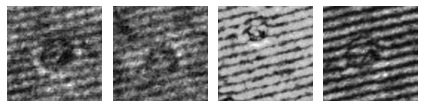

[0. 0. 0. 0.]


In [5]:
# for training batches
imgs, labels = train_batches[6]
plot(imgs)
print(labels[:n])

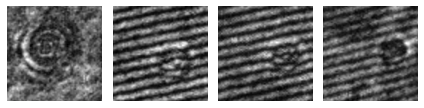

[1. 0. 0. 0.]


In [6]:
# for validation batches
imgs, labels = validation_batches[2]
plot(imgs)
print(labels[:n])

In [7]:
print(train_batches.class_indices)
print(test_batches.class_indices)

{'Cell': 0, 'comp': 1}
{'cell': 0, 'comp': 1}


In [8]:
def block1(input_img):
    c1 = keras.layers.Conv2D(64, 8, 2, activation = 'relu', padding = 'valid')(input_img)
    c2 = keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'valid')(c1)
    c3 = keras.layers.Conv2D(96, 6, activation = 'relu', padding = 'valid')(c2)
    c4 = keras.layers.MaxPooling2D(pool_size = (2,2))(c3)
    c5 = keras.layers.Conv2D(96, 6, activation = 'relu', padding = 'valid')(c4)
    c6 = keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'valid')(c5)
    return c6

def block2(c6):
    c7 = keras.layers.Conv2D(64, 4, activation = 'linear', padding = 'valid')(c6)
    c8 = keras.layers.Conv2D(64, 4, activation = 'tanh', padding = 'valid')(c6)
    c9 = keras.layers.concatenate([c7, c8], axis = -1)
    return c9

def block3(c9):
    c10 = keras.layers.Conv2D(160, 1, activation = 'linear')(c9)
    c11 = keras.layers.Conv2D(60, 4, activation = 'tanh', padding = 'same')(c10)
    c12 = keras.layers.Conv2D(100, 2, activation = 'tanh', padding = 'same')(c10)
    c13 = keras.layers.concatenate([c11, c12], axis = -1)
    return c13

def block4(c13):
    c14 = keras.layers.AveragePooling2D(pool_size = (2,2))(c13)
    c15 = keras.layers.Conv2D(128, 1, activation = 'linear')(c14)
    c16 = keras.layers.Conv2D(64, 4, activation = 'elu', padding = 'valid')(c15)
    c17 = keras.layers.Conv2D(64, 4, activation = 'relu', padding = 'valid')(c15)
    c18 = keras.layers.concatenate([c16, c17], axis = -1)
    return c18

def block5(c18):
    c19 = keras.layers.Conv2D(192, 1, activation = 'linear')(c18)
    c20 = keras.layers.Conv2D(96, 3, activation = 'elu')(c19)
    c21 = keras.layers.Conv2D(96, 3, activation = 'tanh')(c19)
    c22 = keras.layers.concatenate([c20, c21], axis =-1)
    return c22

def block6(c22):
    c23 = keras.layers.Conv2D(256, 1, activation = 'linear')(c22)
    c24 = keras.layers.Conv2D(128, 3, activation = 'elu')(c23)
    c25 = keras.layers.Conv2D(128, 3, activation = 'relu')(c23)
    c26 = keras.layers.concatenate([c24, c25], axis =-1)
    return c26

def block7(c26):
    c27 = keras.layers.Conv2D(320, 1, activation = 'linear')(c26)
    c28 = keras.layers.Conv2D(160, 3, activation = 'elu')(c27)
    c29 = keras.layers.Conv2D(160, 3, activation = 'tanh')(c27)
    c30 = keras.layers.concatenate([c28, c29], axis =-1)
    return c30

def block8(c30):
    c31 = keras.layers.Flatten()(c30)
    keras.layers.Dropout(0.5)
    c32 = keras.layers.Dense(320, activation = 'linear')(c31)
    keras.layers.Dropout(0.5)
    output = keras.layers.Dense(2, activation = 'sigmoid', name = 'output')(c32)
    return output

in_layer = keras.layers.Input(shape = (128,128,1))
w1 = block1(in_layer)
w2 = block2(w1)
w3 = block3(w2)
w4 = block4(w3)
w5 = block5(w4)
w6 = block6(w5)
w7 = block7(w6)
w8 = block8(w7)

model = Model(inputs = in_layer, outputs = w8)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 61, 61, 64)   4160        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 61, 61, 64)   4160        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 56, 56, 96)   221280      ['conv2d_1[0][0]']           

2022-07-25 16:01:00.377773: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-25 16:01:00.377838: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neo11-Inspiron-5402): /proc/driver/nvidia/version does not exist
2022-07-25 16:01:00.379113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 8, 2, kernel_initializer=initializers.RandomNormal(stddev = 1),
    bias_initializer = 'zero', activation = 'relu', padding = 'valid', input_shape = (128,128,1)),
    tf.keras.layers.Conv2D(96, 1, kernel_initializer=initializers.RandomNormal(stddev = 0.1),
    bias_initializer = 'zero', activation = tf.keras.layers.LeakyReLU(0.3), padding = 'valid'),
    tf.keras.layers.Conv2D(128, 6, kernel_initializer=initializers.RandomNormal(stddev = 1),
    bias_initializer = 'zero', activation = 'linear', padding = 'valid'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, 6, kernel_initializer=initializers.RandomNormal(stddev = 0.1),
    bias_initializer = 'zero', activation = scaled_tanh, padding = 'valid'),
    tf.keras.layers.Conv2D(128, 1, kernel_initializer=initializers.RandomNormal(stddev = 0.1),
    bias_initializer = 'zero', activation = 'linear', padding = 'valid'),
    tf.keras.layers.Conv2D(128, 4, activation = 'elu', padding = 'valid'),
    tf.keras.layers.Conv2D(160, 4, activation = scaled_tanh, padding = 'valid'),
    tf.keras.layers.Conv2D(160, 4, activation = scaled_tanh, padding = 'valid'),
    tf.keras.layers.Conv2D(192, 1, activation = 'linear'),
    tf.keras.layers.AveragePooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'valid'),
    tf.keras.layers.Conv2D(256, 3, activation = scaled_tanh, padding = 'valid'),
    tf.keras.layers.Conv2D(256, 3, activation = 'tanh', padding = 'valid'),
    tf.keras.layers.Flatten()
])

x = model.output
output = Dense(units = 2, activation = 'sigmoid')(x)

model = Model(inputs = model.input, outputs = output)

model.summary()

NameError: name 'scaled_tanh' is not defined

In [12]:
# learning rate decay
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True)

# Adam optimizer
optimizer_1 = tf.keras.optimizers.Adam(
    learning_rate = lr_schedule, # lr = 0.001
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-08
)

# compiling model
model.compile(optimizer=optimizer_1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# traing model(optimizer_1)
history = model.fit(
    train_batches,
    validation_data = validation_batches,
    epochs = epochs//10,
    steps_per_epoch=len(train_batches),           # no. of batches in an epoch
    validation_steps = len(validation_batches)
)

print('------------------------------------------------------------------------------------------------------------------')

# test loss and accuracy
test_loss, test_accuracy = model.evaluate(test_batches, steps=len(test_batches))

Epoch 1/10
44/44 [==============================] - 23s 497ms/step - loss: 0.0654 - accuracy: 0.9871 - val_loss: 0.0560 - val_accuracy: 0.9770
Epoch 2/10
44/44 [==============================] - 21s 488ms/step - loss: 0.0439 - accuracy: 0.9814 - val_loss: 0.0411 - val_accuracy: 0.9828
Epoch 3/10
44/44 [==============================] - 22s 498ms/step - loss: 0.0388 - accuracy: 0.9857 - val_loss: 0.0222 - val_accuracy: 0.9885
Epoch 4/10
44/44 [==============================] - 23s 524ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9885
Epoch 5/10
44/44 [==============================] - 24s 547ms/step - loss: 1.0765e-04 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9885
Epoch 6/10
44/44 [==============================] - 24s 541ms/step - loss: 7.2002e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9885
Epoch 7/10
44/44 [==============================] - 24s 542ms/step - loss: 5.2119e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accu

In [12]:
test_loss, test_accuracy = model.evaluate(test_batches, steps=len(test_batches))

14/14 [==============================] - 3s 204ms/step - loss: 0.0236 - accuracy: 0.9908


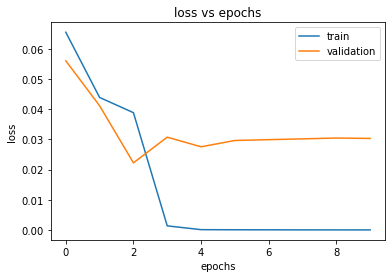

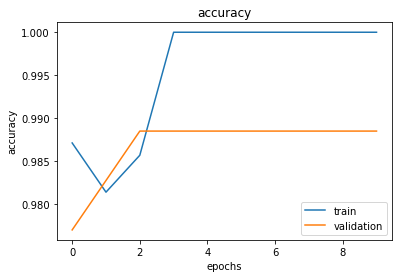

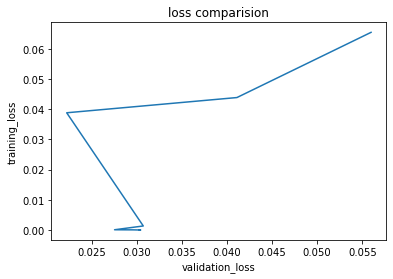

In [13]:
# plotting
plt.plot(history.history['loss'], label = ['train'])
plt.plot(history.history['val_loss'], label =['validation'])
plt.title('loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'],loc='upper right')
plt.show()

# plotting training and validtition accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='lower right')
plt.show()

# plotting training vs validtition loss
plt.plot(history.history['val_loss'],history.history['loss'])
plt.title('loss comparision')

plt.ylabel('training_loss')
plt.xlabel('validation_loss')
plt.show()

In [14]:
# saving model in models trained directory
model.save('/home/neo11/Documents/ML in microfluids/models trained/inception_2')

INFO:tensorflow:Assets written to: /home/neo11/Documents/ML in microfluids/models trained/inception_2/assets


INFO:tensorflow:Assets written to: /home/neo11/Documents/ML in microfluids/models trained/inception_2/assets
